# Meridional Heat Transport

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cosima_cookbook as cc
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import re # extract string

We will use the COSIMA cookbook to find experiments available under a specific model configuration. We will start a session and then state the configuration of our interest.

In [10]:
#Start a COSIMA cookbook session
session = cc.database.create_session()

#Define model configuration of interest
configuration = 'mom01v5'
#configuration = 'mom025'

#Get the experiments available
expts = cc.querying.get_experiments(session, configuration)

#Show results
display(expts)

,experiment,ncfiles
0,woa18,24
1,eac-zstar-v1,29
2,eac-zstar-v2,76
3,025deg_jra55_ryf9091_gadi_norediGM,312
4,025deg_jra55_ryf9091_gadi_noGM,316
...,...,...
171,1deg_jra55_iaf_omip2spunup_cycle50,998
172,1deg_jra55_iaf_omip2spunup_cycle46,1014
173,1deg_jra55_iaf_omip2spunup_cycle49,1014
174,1deg_jra55_iaf_omip2spunup_cycle48,1014


We have identified `025deg_jra55v13_iaf_gmredi6` as a good option that meets our needs. We will now load flux variables from this experiment.  

In [31]:
# We define the experiment of interest
expt = '025deg_jra55v13_iaf_gmredi6'

In [38]:
# Loading temp_yflux_adv_int_z from expt, pick up one year, annual mean and sum xt_ocean
mht = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session, n = 3)

#We will calculate the mean over time and transform units
mht = mht.mean('time')
mht = mht*1e-15

#Finally, we will add up all values across each longitude
mht_xsum = mht.sum('xt_ocean')

#We print the dimensions of the sum file
mht.shape

(1080, 1440)

## Read basin data
Here use NCL script basin.ncl to create basin data (Index: 1 for the Pacific Ocean, 2 for the Atlantic Ocean, 3 for the Indian Ocean.

!!!NOTE: This basin file is ONLY for testing. This version is NOT satisfied. 

In [40]:
# Read basin data
#####################
# INDEX:
#1 Southern Ocean 
#2 Pacific Ocean 
#3 Indian Ocean 
#4 Persian Gulf
#-5 Red Sea 
#6 Atlantic Ocean
#7 Mediterranean Sea 
#8 Labrador Sea 
#9 GIN Sea 
#10 Arctic Ocean 
#11 Hudson Bay 
#-12 Baltic Sea 
#-13 Black Sea 
#-14 Caspian Sea 
#basin = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/MHT/popMask.2700x3600.nc').basin
#####################
# Pacific: 1
# Atlantic: 2
# Indian: 3
#####################
basin = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/MHT/KDS75_01/basin.nc').basin
#print(basin[1000:1100,2400:2500])


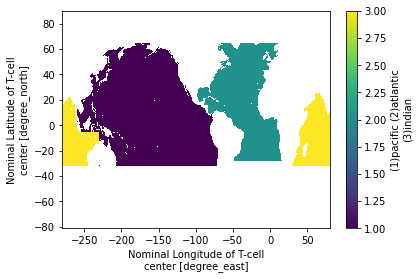

In [49]:
basin.plot()

In [70]:
## Atlantic Ocean
mht_a = basin.where(basin == 2, 1, 0)
mht_a_xsum = np.sum(mht_a, axis = 1)

In [71]:
# Pacific-Indian Ocean
mask_ip = basin.where(basin == 3, 1, 0)
mht_ip_xsum = np.sum(mask_ip, axis = 1)

### Read ERBE Period Ocean and Atmospheric Heat Transport

In [62]:
erbe_mht = []
erbe_lat = []

filename = '/g/data3/hh5/tmp/cosima/observations/original/MHT/obs_vq_am_estimates.txt'

with open(filename) as f:

#   n = len(f.readlines())
    for line in f.readlines()[1:96]:
        #line=line.replace('\n','').split(",")
        line = line.strip()
        sline = line.split()
        erbe_lat.append(float(sline[0]))
        erbe_mht.append(float(sline[3]))
print(erbe_mht)        

[7.82256e-05, -0.00548183, -0.00534277, -0.00778958, -0.0153764, -0.0189109, -0.0172473, -0.0321044, -0.0647783, -0.104008, -0.129806, -0.202605, -0.297446, -0.374377, -0.424618, -0.464923, -0.508466, -0.544651, -0.56517, -0.575634, -0.563567, -0.51931, -0.45106, -0.377069, -0.310393, -0.271679, -0.279999, -0.329881, -0.39744, -0.464742, -0.515384, -0.565431, -0.620221, -0.678495, -0.736833, -0.790937, -0.843637, -0.90752, -0.984516, -1.05272, -1.0956, -1.10212, -1.05218, -0.93882, -0.761357, -0.502307, -0.155427, 0.253559, 0.666604, 1.00846, 1.25254, 1.42962, 1.57235, 1.69269, 1.78862, 1.84355, 1.85095, 1.82898, 1.79722, 1.76105, 1.71365, 1.65596, 1.59826, 1.53441, 1.45553, 1.34517, 1.20096, 1.03473, 0.856831, 0.704894, 0.62273, 0.602973, 0.60382, 0.602437, 0.599438, 0.588678, 0.573292, 0.5557, 0.518399, 0.46073, 0.40554, 0.361088, 0.328643, 0.303888, 0.271855, 0.232879, 0.18562, 0.146825, 0.110927, 0.0737569, 0.0460509, 0.0254577, 0.0100299, 0.00272631, 0.000137086]


### Read NCEP and ECMWF Oceanic and Atmospheric Transport Products

In [63]:
ncep_g_mht = []
ecwmf_g_mht = []
ncep_g_err = []
ecwmf_g_err = []
ncep_a_mht = []
ecwmf_a_mht = []
ncep_a_err = []
ecwmf_a_err = []
ncep_p_mht = []
ecwmf_p_mht = []
ncep_p_err = []
ecwmf_p_err = []
ncep_i_mht = []
ecwmf_i_mht = []
ncep_i_err = []
ecwmf_i_err = []
ncep_ip_mht = []
ecwmf_ip_mht = []
ncep_ip_err = []
ecwmf_ip_err = []
o_lat = []

filename = '/g/data3/hh5/tmp/cosima/observations/original/MHT/ANNUAL_TRANSPORTS_1985_1989.ascii'

with open(filename) as f:

#   n = len(f.readlines())
    for line in f.readlines()[1:]:
        #line=line.replace('\n','').split(",")
        line = line.strip()
        sline = line.split()
        o_lat.append(float(sline[0])*0.01)  # T42 latitudes (north to south)
        ncep_g_mht.append(float(sline[4])*0.01) # Residual Ocean Transport - NCEP
        ecwmf_g_mht.append(float(sline[5])*0.01)# Residual Ocean Transport - ECWMF
        ncep_a_mht.append(float(sline[7])*0.01)# Atlantic Ocean Basin Transport - NCEP
        ncep_p_mht.append(float(sline[8])*0.01)# Pacific Ocean Basin Transport - NCEP
        ncep_i_mht.append(float(sline[9])*0.01)# Indian Ocean Basin Transport - NCEP
        ncep_g_err.append(float(sline[10])*0.01)# Error Bars for NCEP Total Transports
        ncep_a_err.append(float(sline[11])*0.01)# Error Bars for NCEP Atlantic Transports 
        ncep_p_err.append(float(sline[12])*0.01)# Error Bars for NCEP Pacific Transports 
        ncep_i_err.append(float(sline[13])*0.01)# Error Bars for NCEP Indian Transports 
        ecwmf_a_mht.append(float(sline[15])*0.01)# Atlantic Ocean Basin Transport - ECWMF
        ecwmf_p_mht.append(float(sline[16])*0.01)# Pacific Ocean Basin Transport - ECWMF
        ecwmf_i_mht.append(float(sline[17])*0.01)# Indian Ocean Basin Transport - ECWMF
        ecwmf_g_err.append(float(sline[18])*0.01)# Error Bars for ECWMF Total Transports
        ecwmf_a_err.append(float(sline[19])*0.01)# Error Bars for NCEP Atlantic Transports
        ecwmf_p_err.append(float(sline[20])*0.01)# Error Bars for NCEP Pacific Transports
        ecwmf_i_err.append(float(sline[21])*0.01)# Error Bars for NCEP Indian Transports      
ncep_ip_mht = [a+b for a, b in zip(ncep_p_mht,ncep_i_mht)]
ecwmf_ip_mht = [a+b for a, b in zip(ecwmf_p_mht,ecwmf_i_mht)]
ncep_ip_err = [max(a,b) for a, b in zip(ncep_p_err,ncep_i_err)]
ecwmf_ip_err = [max(a,b) for a, b in zip(ecwmf_p_err,ecwmf_i_err)]
len(ncep_ip_mht)

64

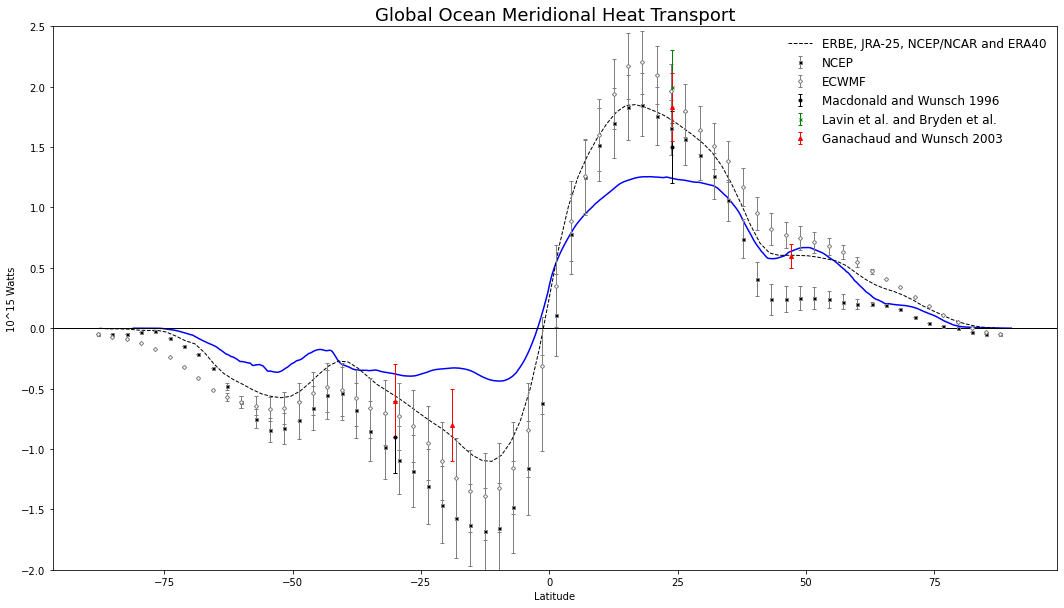

In [80]:
fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(1, 1, 1)
ax.plot(mht.yu_ocean, mht_xsum,'b', label="")
ax.plot(erbe_lat, erbe_mht, 'k--', linewidth=1, label="ERBE, JRA-25, NCEP/NCAR and ERA40")
plt.errorbar(o_lat[::-1], ncep_g_mht[::-1], yerr=ncep_g_err[::-1], c='gray', fmt='s', 
             markerfacecolor='k', markersize=3, capsize=2, linewidth=1, label="NCEP")
plt.errorbar(o_lat[::-1], ecwmf_g_mht[::-1], yerr=ecwmf_g_err[::-1], c='gray', fmt='D', 
             markerfacecolor='white', markersize=3, capsize=2, linewidth=1, label="ECWMF")
plt.errorbar(24, 1.5, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1, 
             label="Macdonald and Wunsch 1996")
plt.errorbar(-30, -0.9, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1)
plt.errorbar(24, 2.0, yerr=0.3, fmt='x', c='green', markersize=3, capsize=2, linewidth=1, 
             label="Lavin et al. and Bryden et al.")
plt.errorbar(24, 1.83, yerr=0.28, fmt='^', c='red', markersize=4, capsize=2, linewidth=1, 
             label="Ganachaud and Wunsch 2003")
plt.errorbar(-30, -0.6, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar(-19, -0.8, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar(47, 0.6, yerr=0.1, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.legend(frameon=False, fontsize=12)
plt.axhline(y=0, linewidth=1, color='black')
plt.ylim(-2,2.5)

plt.title('Global Ocean Meridional Heat Transport', fontsize=18)
plt.xlabel('Latitude')
plt.ylabel('10^15 Watts')

plt.savefig('mht.png')